# Interaction Prediction

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5A-G

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from tqdm import tqdm
import os

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [25]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))

## Example Analysis

With DIP, PID2, and Wan

In [4]:
l3_dir = os.path.join(evaldir, 'L3/')

In [5]:
with open(os.path.join(datadir, 'example_prefix_file.txt')) as f:
    prefixes = f.read().splitlines()

In [28]:
cv_results = []
corum_results = []
panther_results = []
missing = []
for prefix in prefixes:
    for fold in range(1,11):
        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_results.tsv", sep="\t")
            df['network'] = prefix
            df['fold'] = fold
            cv_results.append(df)
    
        except FileNotFoundError:
            missing.append([prefix, fold, 'cv'])
        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_corum_results.tsv", sep="\t")
            
            df['network'] = prefix
            df['fold'] = fold
            corum_results.append(df)
        except FileNotFoundError:
            missing.append([prefix, fold, 'corun'])

        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_panther_results.tsv", sep="\t")
            df['network'] = prefix
            df['fold'] = fold
            panther_results.append(df)
        except FileNotFoundError:
            missing.append([prefix, fold, 'panther'])
            
print('Succeeded: {}'.format(len(cv_results)+len(corum_results)+len(panther_results)))
print('Failed: {}'.format(len(missing)))
print('SELF:',len(cv_results) )
print('CORUM',len(corum_results))
print('PANTHER',len(panther_results))

Succeeded: 90
Failed: 0
SELF: 30
CORUM 30
PANTHER 30


In [49]:
def create_predictions_df(results_list, names, group=None):
    results_df = pd.concat(results_list).reset_index(drop=True)
    results_df['network'] = results_df.network.map(names)
    results_df['pAUPRC_ratio'] = results_df['AUPRC'] / results_df['baseAUPRC']
    if group is not None:
        results_df['Group'] = group
    return results_df

In [50]:
cv_l3_df = create_predictions_df(cv_results, example_names, 'CV')
corum_l3_df = create_predictions_df(corum_results, example_names, 'CORUM')
panther_l3_df = create_predictions_df(panther_results, example_names, 'PANTHER')

In [40]:
def compare_prediction_methods(l3_df, mps_df, metric, partial, net_order=None, plot_type='bar', ax=None, top_n=None, exclude_nets=None, palette=None,):
    l3_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    mps_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    l3_df['method'] = 'L3'
    mps_df['method'] = 'MPS'
    plot_df = pd.concat([l3_df, mps_df])
    plot_df = plot_df[plot_df.partial==partial]
    if exclude_nets is not None:
        plot_df = plot_df[~plot_df.network.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['network'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
    if plot_type=='strip':
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df[plot_df.partial==partial], y='network', x=metric, ax=ax, hue='method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df[plot_df.partial==partial], y='network', x=metric, ax=ax, hue='method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  hue_order=['MPS', 'L3'],palette=palette)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
    elif plot_type == 'bar':
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='network', x=metric, ax=ax, hue='method', order=net_order, hue_order=['MPS', 'L3'], alpha=0.6, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
        if metric=='AUPRC':
            sns.barplot(data=plot_df, y='network', x='baselineAUPRC', ax=ax, hue='method', palette=['grey', 'grey'], order=net_order, alpha=0.5)
        ax.set_xscale('log')
    #plot_metric(plot_df[plot_df.partial==partial], metric=metric, net_order=metric,hue='method', ax=ax1, dodge=True)
    #plot_metric(df2[df2.partial==partial], metric=metric, net_order=metric, ax=ax2)
    return net_order

In [48]:
cv_l3_df

,partial,baselineAUPRC,AUPRC,P@k,network,fold,pAUPRC_ratio,method
0,p@500,0.000024,0.012407,0.158000,DIP,1,522.571670,L3
1,p@test,0.000044,0.022217,0.144118,DIP,1,502.874462,L3
2,p@1%,0.000005,0.002288,0.173469,DIP,1,447.876650,L3
3,p@500,0.000028,0.018780,0.182000,DIP,2,673.420698,L3
4,p@test,0.000049,0.030625,0.157380,DIP,2,620.692348,L3
...,...,...,...,...,...,...,...,...
85,p@test,0.000006,0.001552,0.019765,Wan,9,242.647154,L3
86,p@1%,0.000003,0.001077,0.116438,Wan,9,316.804199,L3
87,p@500,0.000005,0.001441,0.046000,Wan,10,316.062913,L3
88,p@test,0.000007,0.001672,0.021645,Wan,10,241.103737,L3


<AxesSubplot:xlabel='P@k', ylabel='network'>

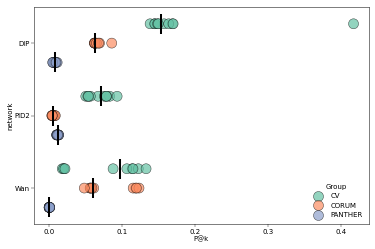

In [77]:
plot_df  = pd.concat([cv_l3_df, corum_l3_df, panther_l3_df])
sns.stripplot(plot_df[plot_df.partial=='p@test'], x = 'P@k', y='network', hue='Group', dodge=0.5, s=10, jitter=False, edgecolor='black', linewidth=0.5, alpha=0.7, 
                hue_order=['CV', 'CORUM', 'PANTHER'], palette='Set2', zorder=1)
sns.pointplot(data = plot_df[plot_df.partial=='p@test'], y='network', x='P@k', hue='Group', dodge=0.53, estimator='median',
                linestyle='none', errorbar=None, marker='|', markersize=20,  hue_order=['CV', 'CORUM', 'PANTHER'],palette=['black', 'black', 'black'], zorder=3, legend=False)

## Figures 5A-C - Interaction Prediction Precision

Load the prediction results from Supplemental Table 4

In [79]:
pred_results = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS4.txt'), sep='\t')

In [88]:
pred_results.columns = ['network', 'fold', 'method', 'Test Set', 'P@k']

In [107]:
def compare_prediction_methods(plot_df, metric, test_set, net_order=None, plot_type='strip', ax=None, top_n=None, exclude_nets=None, palette=None,):
    #l3_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    #mps_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    #l3_df['method'] = 'L3'
    #mps_df['method'] = 'MPS'
    plot_df = plot_df[plot_df['Test Set']==test_set]
    if exclude_nets is not None:
        plot_df = plot_df[~plot_df.network.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['network'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
    if plot_type=='strip':
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df, y='network', x=metric, ax=ax, hue='method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df, y='network', x=metric, ax=ax, hue='method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  hue_order=['MPS', 'L3'],palette=palette, legend=False)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
    elif plot_type == 'bar':
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='network', x=metric, ax=ax, hue='method', order=net_order, hue_order=['MPS', 'L3'], alpha=0.6, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
        if metric=='AUPRC':
            sns.barplot(data=plot_df, y='network', x='baselineAUPRC', ax=ax, hue='method', palette=['grey', 'grey'], order=net_order, alpha=0.5)
        ax.set_xscale('log')
    #plot_metric(plot_df[plot_df.partial==partial], metric=metric, net_order=metric,hue='method', ax=ax1, dodge=True)
    #plot_metric(df2[df2.partial==partial], metric=metric, net_order=metric, ax=ax2)
    return net_order

In [ ]:
_, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(15, 10), gridspec_kw={'wspace': 0.5})
compare_prediction_methods(pred_results, 'P@k', test_set='Held-out', net_order='P@k', ax=ax1)
compare_prediction_methods(pred_results, 'P@k', test_set='CORUM', net_order='P@k', ax=ax2)
compare_prediction_methods(pred_results, 'P@k', test_set='PANTHER', net_order='P@k', ax=ax3)
plt.savefig(os.path.join(figdir, 'Fig5ABC_prediciton_results.jpg'), dpi=300, bbox_inches='tight')

## Figure 5D - Network Coverage of Predicted Interactions

In [118]:
coverage_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5D_interaction_coverage.csv'))

In [128]:
def plot_coverage_stats(coverage_df, ax=None, order=None, **kwargs):
    coverage_stats =coverage_df.drop_duplicates(subset=['network', 'fold']).dropna().set_index('Name')
    stack_data = coverage_stats.groupby(['Name']).mean().loc[:, ('0-1', '2-5', '6-10', '11-20', '21+')]
    return_order=False
    if order is None:
        order=list(stack_data.sort_values(by=['21+', '11-20', '6-10', '2-5', '0-1'], ascending=False).index)
        return_order=True
    if ax is None:
        _ = plt.figure(figsize=(10, 2))
        ax= plt.gca()
    stack_data.loc[order].plot(kind='bar', stacked=True, edgecolor='black', ax=ax, color=['#b8de29', '#73d055', '#29af7f', '#238a8d', '#33638d'][::-1], **kwargs)
    if return_order:
        return order

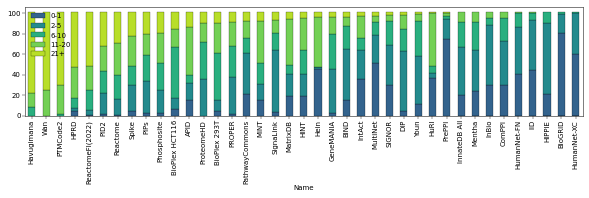

In [129]:
_ = plot_coverage_stats(coverage_df[coverage_df.method=='L3'])

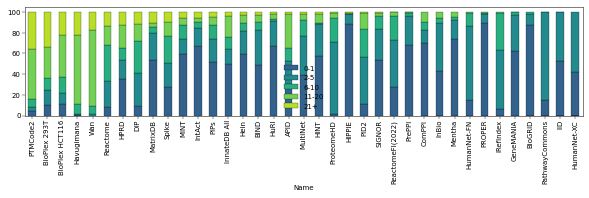

In [125]:
_ = plot_coverage_stats(coverage_df[coverage_df.method=='MPS'])

## Figure 5E - Network Coverage vs AF ipTM

## Figure 5F - ipTM of sample network interactions

## Figure 5G - ipTM of potentially novel predicted interactions